## Preparing the Environment

In [55]:
from __future__ import print_function
import numpy as np
from scipy.optimize import curve_fit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from ifqi import envs
from ifqi.evaluation import evaluation
from ifqi.algorithms.fqi import FQI

%matplotlib inline
#%matplotlib notebook

In [3]:
env = envs.LQG1D()
state_dim, action_dim, reward_dim = envs.get_space_info(env)
reward_idx = state_dim + action_dim

dataset = evaluation.collect_episodes(env, n_episodes=100)
sast = np.append(dataset[:, :reward_idx],
                 dataset[:, reward_idx + reward_dim:-1],
                 axis=1)
r = dataset[:, reward_idx]



In [4]:
states = discrete_states  = np.linspace(-10, 10, 20)
actions = discrete_actions = np.linspace(-8, 8, 20)

initial_states = np.array([[1, 2, 5, 7, 10]]).T

def make_grid(x, y):
    m = np.meshgrid(x, y, copy=False, indexing='ij')
    return np.vstack(m).reshape(2, -1).T
    

SA = make_grid(states, actions)
S, A = SA[:, 0], SA[:, 1]

## Evaluating the Optimal Q

Optimal K: [[-0.61525125]] Covariance S: 0.001


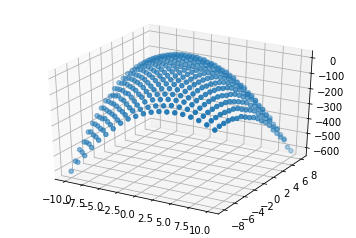

In [5]:
K, cov = env.computeOptimalK(), 0.001
print('Optimal K: {} Covariance S: {}'.format(K, cov))

Q_fun_ = np.vectorize(lambda s, a: env.computeQFunction(s, a, K, cov, 1))
Q_fun = lambda X: Q_fun_(X[:, 0], X[:, 1])

Q_opt = Q_fun(SA)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, Q_opt)

In [6]:
class QPolicy:
    def __init__(self, Q):
        self.Q = Q
    
    def draw_action(self, states, absorbing=False, evaluation=False):
        v = self.Q(make_grid(states, actions))
        return actions[v.argmax()]

class OptimalPolicy:
    K = env.computeOptimalK()[0][0]
    
    def draw_action(self, states, absorbing, evaluation=False):
        i = np.abs(actions - self.K*states).argmin()
        #print("states: {} action: {}".format(states, discrete_actions[i]))
        return discrete_actions[i]

def evaluateP(policy, i=initial_states):
    values = evaluation.evaluate_policy(env, policy, initial_states=i)
    print("values (mean {:8.2f},  se {:8.2f})\n steps (mean {:8.2f},  se {:8.2f})".format(*values))
    return values

def evaluateQ(Q, i=initial_states):
    return evaluateP(QPolicy(Q), i)

optimalP = QPolicy(Q_fun)
#optimalP = OptimalPolicy()
_ = evaluateP(optimalP)

values (mean   -65.58,  se    47.21)
 steps (mean   100.00,  se     0.00)


# Learning with FQI and `curve_fit` regressor

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

class Regressor(object):
    __slots__ = ('b', 'k')
    
    def __init__(self, b=0, k=0):
        self.b = b
        self.k = k
        
    @property
    def theta(self):
        return (self.b, self.k)
    
    @theta.setter
    def theta(self, value):
        self.b, self.k = value
    
    def fit(self, X, y):
        #print("fitting: ", end='')
        (self.b, self.k), pcov = curve_fit(self.Q, X, y, p0=[self.b-0.0001, self.k-0.0001])
        #print(self.b, self.k)
    
    def Q(self, sa, b, k):
        #return b - (sa[:, 1] - k *  sa[:, 0]) ** 2
        s, a = sa[:, 0], sa[:, 1]
        return - b * b * s * a - 0.5 * k * a * a - 0.4* k * s * s
    
    def predict(self, X=SA):
        return self.Q(X, self.b, self.k)
    
    def evaluate(self, X=SA):
        Q_hat = self.predict(X)
        Q_opt = Q_fun(X)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X[:, 0], X[:, 1], Q_opt)
        ax.scatter(X[:, 0], X[:, 1], Q_hat, c='r', marker='^')
        
        mae = mean_absolute_error(Q_opt, Q_hat)
        mse = mean_squared_error(Q_opt, Q_hat)
        
        print("       ( mse {:8.2f}, mae {:8.2f})".format(mse, mae))
        print(" theta (   b {:8.2f},   k {:8.2f})".format(*self.theta))

        evaluateQ(self.predict)
        return Q_hat
        
    

## Evaluating regressor using Optimal data

       ( mse    96.20, mae     7.73)
 theta (   b    -1.70,   k     5.35)
values (mean   -66.11,  se    48.13)
 steps (mean   100.00,  se     0.00)


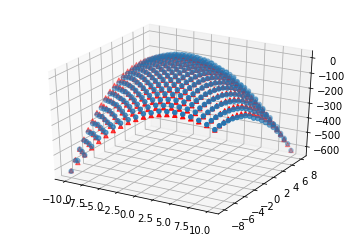

In [8]:
regressor_opt = Regressor()
regressor_opt.fit(SA, Q_opt)

Q_hat = regressor_opt.evaluate()

## Using FQI

In [9]:
regressor = Regressor()
fqi = FQI(estimator=regressor,
          state_dim=state_dim,
          action_dim=action_dim,
          discrete_actions=actions,
          gamma=env.gamma,
          horizon=env.horizon,
          verbose=False)

In [10]:
sa, y = fqi.partial_fit(sast, r)

iterations = 100
for i in range(iterations):
    sa, y = fqi.partial_fit()
    #regressor.evaluate(sa)
    #plt.show()

/home/tyrion/.local/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


       ( mse 71744.31, mae   182.97)
 theta (   b    -2.87,   k    12.23)
values (mean   -65.22,  se    47.42)
 steps (mean   100.00,  se     0.00)


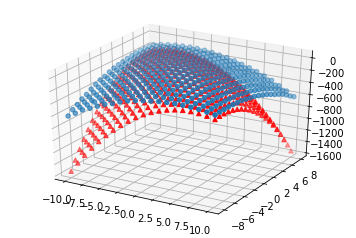

In [11]:
pred = regressor.evaluate()

## Show how Theta changes

In [12]:
import copy

regressor0 = Regressor()
fqi0 = FQI(estimator=regressor0,
          state_dim=state_dim,
          action_dim=action_dim,
          discrete_actions=actions,
          gamma=env.gamma,
          horizon=env.horizon,
          verbose=False)
fqi0.partial_fit(sast, r)

@np.vectorize
def compute_gradient(b, k):
    fqi = copy.deepcopy(fqi0)
    fqi._estimator.theta = (b, k)
    fqi.partial_fit()
    return fqi._estimator.theta

/home/tyrion/.local/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [82]:
B_i, K_i = np.mgrid[-5:5:20j, -5:20:20j]
# B_i, K_i = np.mgrid[-6:6:40j, -5:35:40j]
B_f, K_f = compute_gradient(B_i, K_i)

/home/tyrion/.local/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


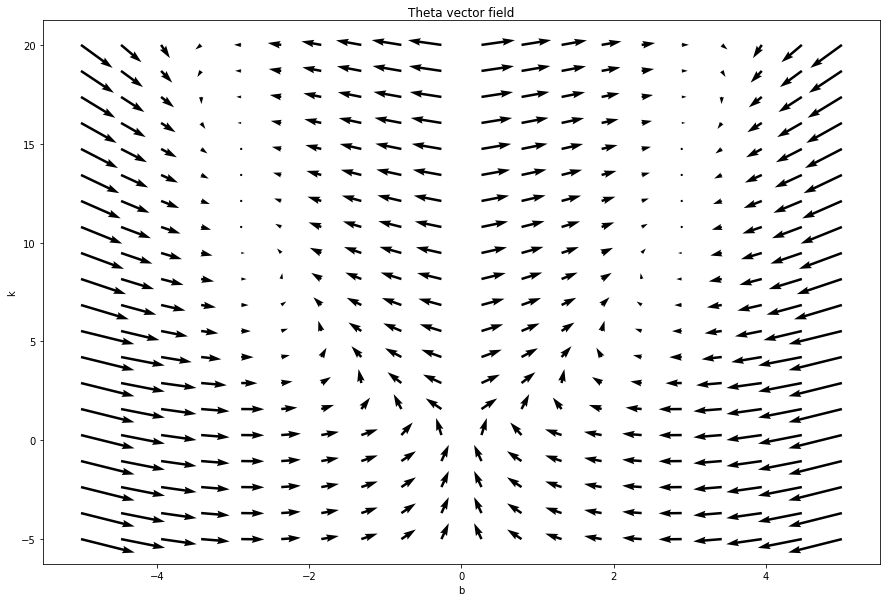

In [87]:
fig = plt.figure(figsize=(15,10))
Q = plt.quiver(B_i, K_i, B_f-B_i, K_f-K_i, angles='xy')
#plt.axis('equal')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.axis([-20, 20, -10, 30])

# --- OLD ---
# Q = plt.quiver(B_i, K_i, B_f-B_i, K_f-K_i, angles='xy')

plt.xlabel('b')
plt.ylabel('k')
plt.title('Theta vector field')
plt.savefig('grad_field.png', bbox_inches='tight')

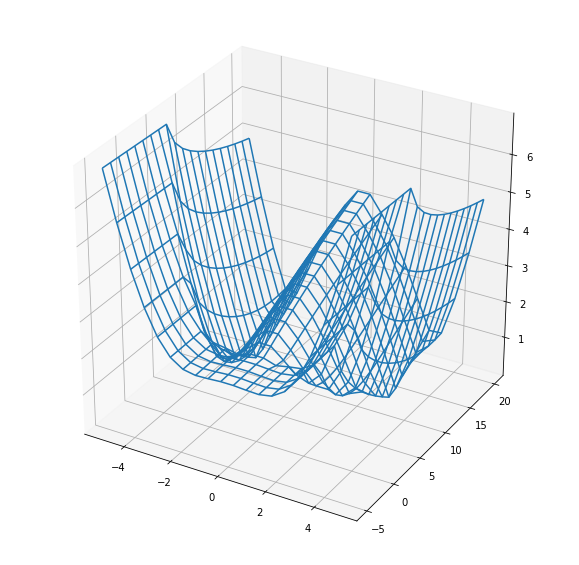

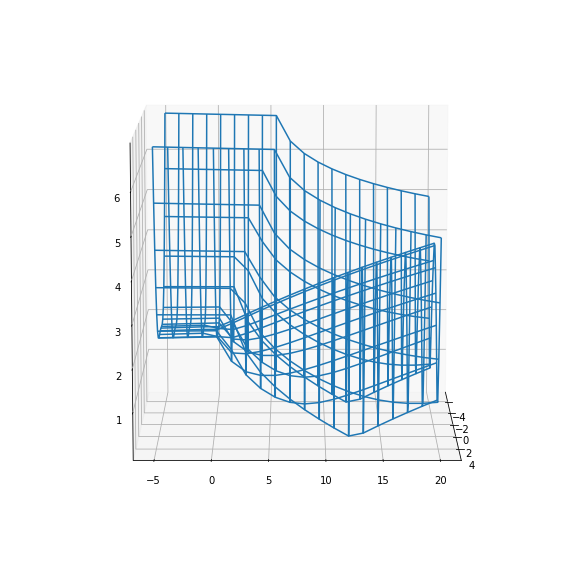

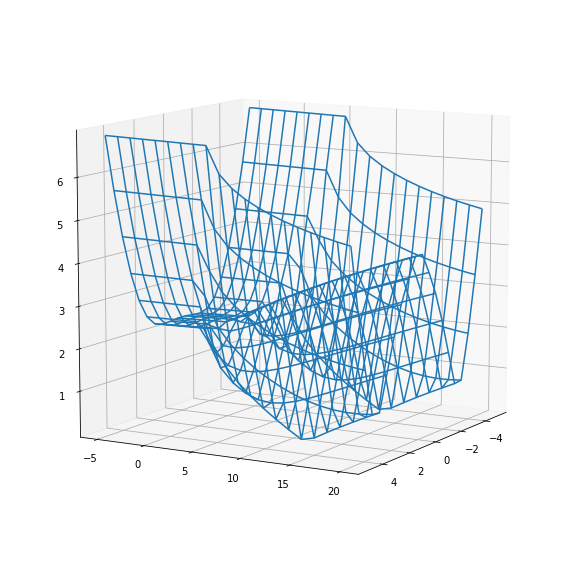

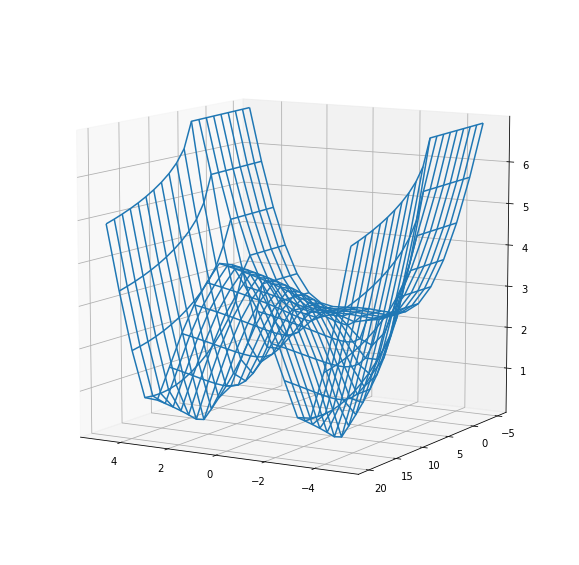

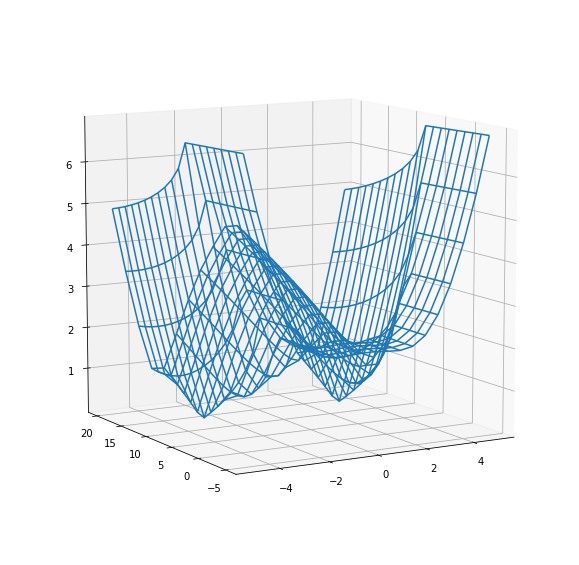

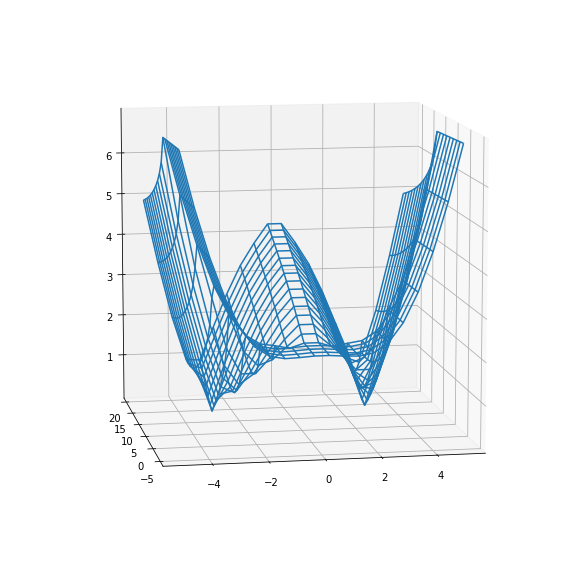

In [92]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
Z = ((B_f-B_i)**2 + (K_f-K_i)**2)**0.5
ax.plot_wireframe(B_i, K_i, Z)


for angle in [0, 30, 120, 240, 260]:
    fig = plt.figure(figsize=(10,10))
    plt.title('angle: {}'.format(angle))
    ax = fig.add_subplot(111, projection='3d')
    Z = ((B_f-B_i)**2 + (K_f-K_i)**2)**0.5
    ax.plot_wireframe(B_i, K_i, Z)
    ax.view_init(10, angle)
    plt.draw()

#plt.savefig('wireframe.png', bbox_inches='tight')

FQI value:
 b: 2.5, k: -4, coef: 1.5625
 b: 3.119825692769919e-05, k: -3.5422231388383323, coef: 2.747797632099296e-10
 b: 5.373640141433355e-06, k: -1.324333232878552, coef: 2.180418617666145e-11
 b: 3.429677475101704e-06, k: 0.9117911932961448, coef: -1.2900637415346853e-11
 b: 0.8499760934638232, k: 3.1485174867436454, coef: -0.2294601705411602
 b: 1.543928252714909, k: 5.216369716563885, coef: -0.45696807915323656
 b: 1.9270788105410694, k: 6.836038861793961, coef: -0.543243363169212
 b: 2.18004388547524, k: 8.095550819728938, coef: -0.5870621343041748
 b: 2.357988302364253, k: 9.073582298699865, coef: -0.6127798978451265
 b: 2.487403446218982, k: 9.832811783010024, coef: -0.6292377033955638
 b: 2.5834035173285885, k: 10.422125613856268, coef: -0.6403658889384946
FQI value:
 b: -6, k: 4, coef: -9.0
 b: -6.078178047133197e-05, k: -3.8371415122824, coef: 9.628065124623677e-10
 b: 2.417839117672692e-05, k: -1.6216569761242992, coef: 3.604921438391897e-10
 b: 1.6886303275280846e-06, k:

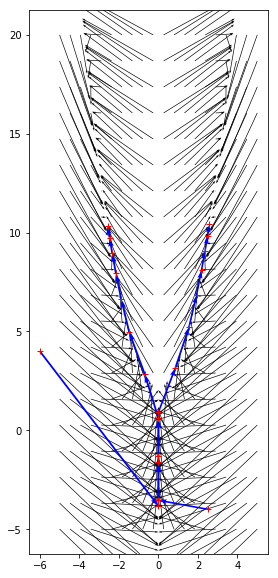

In [93]:
BV = [2.5, -6]
KV = [-4, 4]

fig = plt.figure(figsize=(15,10))
Q = plt.quiver(B_i, K_i, B_f-B_i, K_f-K_i, units='xy', scale=1)
plt.axis('equal')
plt.gca().set_aspect('equal', adjustable='box')


for b, k in zip(BV, KV):

    regressor= Regressor()
    fqi = FQI(estimator=regressor,
              state_dim=state_dim,
              action_dim=action_dim,
              discrete_actions=actions,
              gamma=env.gamma,
              horizon=env.horizon,
              verbose=False)
    fqi.partial_fit(sast, r)
    fqi._estimator.theta = (b, k)
    L = [fqi._estimator.theta]
    plt.plot(L[-1][0], L[-1][1], '+r')
    for i in range(10):
        fqi.partial_fit()
        L.append(fqi._estimator.theta)
        plt.plot(L[-1][0], L[-1][1], '+r')
        plt.quiver(L[-2][0], L[-2][1],L[-1][0]-L[-2][0], L[-1][1]-L[-2][1], units='xy',color='b', scale=1)
    print('FQI value:')
    for el in L:
        b, k = el
        print(' b: {}, k: {}, coef: {}'.format(b, k, -b**2/k))
    plt.savefig('fqi_steps.png', bbox_inches='tight')

In [14]:
stop

NameError: name 'stop' is not defined

In [ ]:
def soft_relu(D, a_1, a_2, a_3, a_4, b_1, b_2):
    A = np.array([[a_1,a_2],[a_3, a_4]])
    V = np.dot(D,A) + np.array([b_1, b_2])
    C = np.column_stack((V.sum(axis=1), np.zeros(V.shape[0])))
    return np.max(C, axis=1)
    #return np.log(1. + np.exp(V.sum(axis=1)))

X = np.column_stack((B_i.ravel(), K_i.ravel()))

from lmfit import  Model, Minimizer, Parameters, fit_report

gmod = Model(soft_relu)
result = gmod.fit(B_f.ravel(), D=X, a_1=1., a_2=1., a_3=1., a_4=1., b_1 = 0., b_2=0.)
# print(result.fit_report())

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(B_i, K_i, B_f)
ax.scatter(X[:,0], X[:,1], result.best_fit, c='r', marker='d')
ax.set_xlabel('b')
ax.set_ylabel('k')
ax.set_zlabel('b')
plt.title('euclidean - b')
print()
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_true=B_f.ravel(), y_pred=result.best_fit))))

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(3), Ridge())

X = np.column_stack((B_i.ravel(), K_i.ravel()))

model.fit(X, B_f.ravel())
y_plot = model.predict(X)

print(model.steps[0][1].transform(X).shape)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(B_i, K_i, B_f)
ax.scatter(X[:,0], X[:,1], y_plot, c='r', marker='d')
ax.set_xlabel('b')
ax.set_ylabel('k')
ax.set_zlabel('distance')
plt.title('polar - distance')
print()
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_true=B_f.ravel(), y_pred=y_plot))))

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(2), Ridge())

X = np.column_stack((B_i.ravel(), K_i.ravel()))

model.fit(X, K_f.ravel())
y_plot = model.predict(X)

print(model.steps[0][1].transform(X).shape)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(B_i, K_i, K_f)
ax.scatter(X[:,0], X[:,1], y_plot, c='r', marker='d')
ax.set_xlabel('b')
ax.set_ylabel('k')
ax.set_zlabel('distance')
plt.title('polar - distance')
print()
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_true=K_f.ravel(), y_pred=y_plot))))

# Polar coordinates

In [ ]:
X = B_f - B_i
Y = K_f - K_i

polar_r = np.sqrt(X**2 + Y**2) # distance
polar_a = np.arctan2(Y, X) # angle    

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(B_i, K_i, polar_r)
ax.set_xlabel('b')
ax.set_ylabel('k')
ax.set_zlabel('r (distance)')


In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(B_i, K_i, polar_a)
ax.set_xlabel('b')
ax.set_ylabel('k')
ax.set_zlabel('angle')

In [ ]:
# reconstruction
dx = polar_r * np.cos(polar_a)
dy = polar_r * np.sin(polar_a)

B_fr = B_i + dx
K_fr = K_i + dy
print(np.allclose(B_fr,B_f))
print(np.allclose(K_fr,K_f))

In [ ]:
def atan_f(D, a_1, a_2, a_3, a_4, b_1, b_2):
    A = np.array([[a_1,a_2],[a_3, a_4]])
    V = np.dot(D,A) + np.array([b_1, b_2])
    return np.arctan2(V[:,1], V[:,0])

Y_1 = np.cos(polar_a.ravel())
Y_2 = np.sin(polar_a.ravel())
Y = np.column_stack((Y_1, Y_2))
X = np.column_stack((B_i.ravel(), K_i.ravel()))

from lmfit import  Model, Minimizer, Parameters, fit_report

gmod = Model(atan_f)
result = gmod.fit(polar_a.ravel(), D=X, a_1=1., a_2=1., a_3=1., a_4=1., b_1=0, b_2=0)
# print(result.fit_report())

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(B_i, K_i, polar_a)
ax.scatter(X[:,0], X[:,1], result.best_fit, c='r', marker='d')
ax.set_xlabel('b')
ax.set_ylabel('k')
ax.set_zlabel('angle')
plt.title('polar - angle')
print()
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_true=polar_a.ravel(), y_pred=result.best_fit))))

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(6), Ridge())

X = np.column_stack((B_i.ravel(), K_i.ravel()))

model.fit(X, polar_r.ravel())
y_plot = model.predict(X)

print(model.steps[0][1].transform(X).shape)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(B_i, K_i, polar_r)
ax.scatter(X[:,0], X[:,1], y_plot, c='r', marker='d')
ax.set_xlabel('b')
ax.set_ylabel('k')
ax.set_zlabel('distance')
plt.title('polar - distance')
print()
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_true=polar_r.ravel(), y_pred=y_plot))))